# Learn VAE on Game datasets


## Standard-Imports


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install keras


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.



## Loading Datasets

- Gym datasets will be used. The first test is about pong which has the most simple images.


In [3]:

game_name = "Pong"
output = "v0"

downsampled = []
original = []
actions = []
rewards = []

import os
record_files = [filename for filename in os.listdir(f'./record/{game_name}')
                    if os.path.isfile(f"./record/{game_name}/{filename}") and filename.startswith(f"record_{game_name}_{output}")]
for file in record_files[0:10]:
    print("load file: ", file)
    data = np.load(f"./record/{game_name}/{file}", allow_pickle=True)
    if len(downsampled) == 0:
        downsampled = data["obs_downsampled"]
        original = data["obs_original"]
        actions = data["actions"]
        rewards = data["rewards"]
    else:
        downsampled = np.concatenate((downsampled, data["obs_downsampled"]))
        original = np.concatenate((original, data["obs_original"]))
        actions = np.concatenate((actions, data["actions"]))
        rewards = np.concatenate((rewards, data["rewards"]))

downsampled = downsampled / 255.
original = original / 255.

print("loaded downsampled: ", downsampled.shape)
print("loaded original: ", original.shape)
print("loaded actions: ", actions.shape)
print("loaded rewards: ", rewards.shape)


load file:  record_Pong_v0_0.npz
load file:  record_Pong_v0_1.npz
load file:  record_Pong_v0_10.npz
load file:  record_Pong_v0_100.npz
load file:  record_Pong_v0_101.npz
load file:  record_Pong_v0_102.npz
load file:  record_Pong_v0_103.npz
load file:  record_Pong_v0_104.npz
load file:  record_Pong_v0_105.npz
load file:  record_Pong_v0_11.npz
loaded downsampled:  (13423, 64, 64, 3)
loaded original:  (13423, 210, 160, 3)
loaded actions:  (13423,)
loaded rewards:  (13423,)


short test of trainings process with train test split


In [4]:
from sklearn.model_selection import train_test_split
obs_train, obs_test, actions_train, actions_test, rewards_train, rewards_test = train_test_split(original, actions, rewards,
                                                    test_size=0.25, shuffle=False)


In [4]:
print(obs_train.shape)
print(actions_train.shape)


(10067, 210, 160, 3)
(10067,)


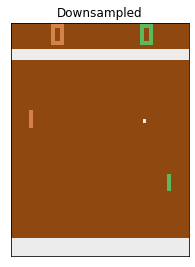

(10067, 210, 160, 3)


In [5]:
import random
index = random.choice(range(len(obs_train)))
plt.imshow(obs_train[index,:,:,:])
plt.title("Downsampled")
plt.tight_layout()
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.show()

print(obs_train.shape)

## Simple Auto-Encoder


In [6]:

def pad_along_axis(array: np.ndarray, target_length, axis=0):

    npad = [(0, 0) for _ in range(len(array.shape))]

    for axes in axis:
        
        pad_size = (target_length - array.shape[axes])
        if pad_size % 2 == 0:
            npad[axes] = (pad_size//2, pad_size//2)
        else:
            npad[axes] = (pad_size//2, pad_size//2+1)

    b = np.pad(array, pad_width=npad, mode='constant', constant_values=0)

    return b


### test padding


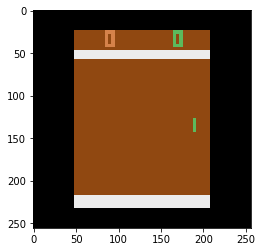

In [7]:

b = pad_along_axis(obs_train[1:3,:,:,:], 256, axis=[1,2])

plt.imshow(b[0,:,:,:])
plt.show()


In [14]:

import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(210, 160, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [15]:
autoencoder.fit(obs_train, obs_train,
                epochs=1,
                batch_size=1024,
                shuffle=True,
                validation_data=(obs_test, obs_test))


ValueError: Error when checking target: expected conv2d_19 to have shape (212, 160, 3) but got array with shape (210, 160, 3)

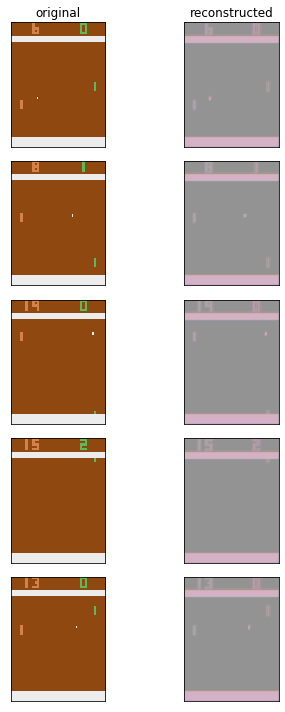

In [32]:

decoded_imgs = autoencoder.predict(obs_test / 255.)

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i in range(n):
    # display original
    ax[i,0].imshow(obs_test[i,:,:,:].reshape(210, 160, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(decoded_imgs[i,:,:,:].reshape(210, 160, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    if i == 0:
        ax[i,0].set_title("original")
        ax[i,1].set_title("reconstructed")
        
plt.tight_layout()
plt.show()
    

In [36]:
print(actions[0:4])



[array([0]) 1 1 5]



## Simple Convolutional Variational Auto-Encoder


In [14]:

import numpy as np
import json
import tensorflow as tf
import os


def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


class ConvVAE(object):
    def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001, kl_tolerance=0.5, is_training=False,
                 reuse=False, gpu_mode=False, input_size=None, kloss_constant = 1):
        self.z_size = z_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.is_training = is_training
        self.kl_tolerance = kl_tolerance
        self.reuse = reuse
        self.input_size = input_size
        self.kloss_constant = kloss_constant

        with tf.variable_scope('conv_vae', reuse=self.reuse):
            if not gpu_mode:
                with tf.device('/cpu:0'):
                    tf.logging.info('Model using cpu.')
                    self._build_graph()
            else:
                tf.logging.info('Model using gpu.')
                self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            if self.input_size is None:
                self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
            else:
                self.x = tf.placeholder(tf.float32, shape=[None, *self.input_size])

            # Encoder
            h = tf.layers.conv2d(self.x, 8, 4, strides=2, activation=tf.nn.relu, name="enc_conv1")
            h = tf.layers.conv2d(h, 16, 4, strides=2, activation=tf.nn.relu, name="enc_conv2")
            h = tf.layers.conv2d(h, 32, 4, strides=2, activation=tf.nn.relu, name="enc_conv3")
            h = tf.layers.conv2d(h, 64, 4, strides=2, activation=tf.nn.relu, name="enc_conv4")
            h = tf.layers.conv2d(h, 128, 4, strides=2, activation=tf.nn.relu, name="enc_conv5")
            h = tf.layers.conv2d(h, 256, 4, strides=2, activation=tf.nn.relu, name="enc_conv6")
            h = tf.reshape(h, [-1, 2 * 2 * 256])

            # VAE
            self.mu = tf.layers.dense(h, self.z_size, name="enc_fc_mu")
            self.logvar = tf.layers.dense(h, self.z_size, name="enc_fc_log_var")
            self.sigma = tf.exp(self.logvar / 2.0)
            self.epsilon = tf.random_normal([self.batch_size, self.z_size])
            self.z = self.mu + self.sigma * self.epsilon

            # Decoder
            h = tf.layers.dense(self.z, 4 * 256, name="dec_fc")
            h = tf.reshape(h, [-1, 1, 1, 4 * 256])
            h = tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="dec_deconv1")
            h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="dec_deconv2")
            h = tf.layers.conv2d_transpose(h, 32, 5, strides=2, activation=tf.nn.relu, name="dec_deconv3")
            h = tf.layers.conv2d_transpose(h, 16, 5, strides=2, activation=tf.nn.relu, name="dec_deconv4")
            h = tf.layers.conv2d_transpose(h, 8, 6, strides=2, activation=tf.nn.relu, name="dec_deconv5")
            self.y = tf.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="dec_deconv6")

            # train ops
            if self.is_training:
                self.global_step = tf.Variable(0, name='global_step', trainable=False)

                eps = 1e-6  # avoid taking log of zero

                # reconstruction loss
                self.r_loss = tf.reduce_sum(
                    tf.square(self.x - self.y),
                    reduction_indices=[1, 2, 3]
                )
                self.r_loss = tf.reduce_mean(self.r_loss)

                # augmented kl loss per dim
                self.kl_loss = - 0.5 * tf.reduce_sum(
                    (1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
                    reduction_indices=1
                )
                self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
                self.kl_loss = tf.reduce_mean(self.kl_loss)
                self.kl_loss = self.kl_loss * self.kloss_constant

                self.loss = self.r_loss + self.kl_loss

                # training
                self.lr = tf.Variable(self.learning_rate, trainable=False)
                self.optimizer = tf.train.AdamOptimizer(self.lr)
                grads = self.optimizer.compute_gradients(self.loss)  # can potentially clip gradients here.

                self.train_op = self.optimizer.apply_gradients(
                    grads, global_step=self.global_step, name='train_step')

            # initialize vars
            self.init = tf.global_variables_initializer()

            t_vars = tf.trainable_variables()
            self.assign_ops = {}
            for var in t_vars:
                # if var.name.startswith('conv_vae'):
                pshape = var.get_shape()
                pl = tf.placeholder(tf.float32, pshape, var.name[:-2] + '_placeholder')
                assign_op = var.assign(pl)
                self.assign_ops[var] = (assign_op, pl)

    def _init_session(self):
        """Launch TensorFlow session and initialize variables"""
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def close_sess(self):
        """ Close TensorFlow session """
        self.sess.close()

    def encode(self, x):
        return self.sess.run(self.z, feed_dict={self.x: x})

    def encode_mu_logvar(self, x):
        (mu, logvar) = self.sess.run([self.mu, self.logvar], feed_dict={self.x: x})
        return mu, logvar

    def decode(self, z):
        return self.sess.run(self.y, feed_dict={self.z: z})

    def get_model_params(self):
        # get trainable params.
        model_names = []
        model_params = []
        model_shapes = []
        with self.g.as_default():
            t_vars = tf.trainable_variables()
            for var in t_vars:
                # if var.name.startswith('conv_vae'):
                param_name = var.name
                p = self.sess.run(var)
                model_names.append(param_name)
                params = np.round(p * 10000).astype(np.int).tolist()
                model_params.append(params)
                model_shapes.append(p.shape)
        return model_params, model_shapes, model_names

    def get_random_model_params(self, stdev=0.5):
        # get random params.
        _, mshape, _ = self.get_model_params()
        rparam = []
        for s in mshape:
            # rparam.append(np.random.randn(*s)*stdev)
            rparam.append(np.random.standard_cauchy(s) * stdev)  # spice things up
        return rparam

    def set_model_params(self, params):
        with self.g.as_default():
            t_vars = tf.trainable_variables()
            idx = 0
            for var in t_vars:
                # if var.name.startswith('conv_vae'):
                pshape = tuple(var.get_shape().as_list())
                p = np.array(params[idx])
                assert pshape == p.shape, "inconsistent shape"
                assign_op, pl = self.assign_ops[var]
                self.sess.run(assign_op, feed_dict={pl.name: p / 10000.})
                idx += 1

    def load_json(self, jsonfile='vae.json'):
        with open(jsonfile, 'r') as f:
            params = json.load(f)
        self.set_model_params(params)

    def save_json(self, jsonfile='vae.json'):
        model_params, model_shapes, model_names = self.get_model_params()
        qparams = []
        for p in model_params:
            qparams.append(p)
        with open(jsonfile, 'wt') as outfile:
            json.dump(qparams, outfile, sort_keys=True, indent=0, separators=(',', ': '))

    def set_random_params(self, stdev=0.5):
        rparam = self.get_random_model_params(stdev)
        self.set_model_params(rparam)

    def save_model(self, model_save_path):
        sess = self.sess
        with self.g.as_default():
            saver = tf.train.Saver(tf.global_variables())
        checkpoint_path = os.path.join(model_save_path, 'vae')
        tf.logging.info('saving model %s.', checkpoint_path)
        saver.save(sess, checkpoint_path, 0)  # just keep one

    def load_checkpoint(self, checkpoint_path):
        sess = self.sess
        with self.g.as_default():
            saver = tf.train.Saver(tf.global_variables())
        ckpt = tf.train.get_checkpoint_state(checkpoint_path)
        print('loading model', ckpt.model_checkpoint_path)
        tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)



In [15]:

# Hyperparameters for ConvVAE
z_size=32
batch_size=64
learning_rate=0.0001
kl_tolerance=0.5

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True,
              input_size=[256, 256, 3],
              kloss_constant=1000)

reset_graph()


INFO:tensorflow:Model using gpu.
num_batches per epoch = 157
train step loss recon_loss kl_loss
epoch: 0
step 10 49178.406 33178.406 16000.0
step 20 49143.02 33143.02 16000.0
step 30 49044.945 33044.945 16000.0
step 40 48251.33 32251.328 16000.0
step 50 46859.707 30859.707 16000.0
step 60 45269.02 29269.02 16000.0
step 70 43223.09 27223.09 16000.0
step 80 39913.68 23913.682 16000.0
step 90 37065.277 21065.277 16000.0
step 100 34842.68 18842.678 16000.0
step 110 33112.734 17112.732 16000.0
step 120 31511.516 15511.515 16000.0
step 130 29606.436 13606.436 16000.0
step 140 27795.844 11795.843 16000.0
step 150 26696.062 10696.062 16000.0


In [30]:
total_epochs = 10


In [33]:

NUM_EPOCH = 10
dataset = obs_train

total_length = len(dataset)

num_batches = int(np.floor(total_length/batch_size))
print(f"num_batches per epoch = {num_batches}")

# train loop:

print("train", "step", "loss", "recon_loss", "kl_loss")
for epoch in range(NUM_EPOCH):
  print(f"epoch: {epoch}")
  np.random.shuffle(dataset)
  for idx in range(num_batches):
    batch = dataset[idx*batch_size:(idx+1)*batch_size]

    obs = batch.astype(np.float)
    obs = pad_along_axis(obs, 256, axis=[1,2])

    feed = {vae.x: obs,}

    (train_loss, r_loss, kl_loss, train_step, _) = vae.sess.run([
      vae.loss, vae.r_loss, vae.kl_loss, vae.global_step, vae.train_op
    ], feed)
  
    if ((train_step+1) % 10 == 0):
      print("step", (train_step+1), train_loss, r_loss, kl_loss)
  
  total_epochs += 1  
  vae.save_json(f"tf_vae/vae_epochs_{game_name}_{total_epochs}.json")
          

num_batches per epoch = 157
train step loss recon_loss kl_loss
epoch: 0
step 3150 16100.04 100.040504 16000.0
step 3160 16100.282 100.28192 16000.0
step 3170 16097.999 97.99899 16000.0
step 3180 16099.602 99.601425 16000.0
step 3190 16099.026 99.02638 16000.0
step 3200 16097.066 97.06654 16000.0
step 3210 16098.054 98.054 16000.0
step 3220 16096.927 96.92647 16000.0
step 3230 16096.434 96.43404 16000.0
step 3240 16097.278 97.27867 16000.0
step 3250 16096.429 96.42883 16000.0
step 3260 16097.472 97.471634 16000.0
step 3270 16095.742 95.669685 16000.072
step 3280 16096.157 96.15708 16000.0
step 3290 16097.3125 97.3123 16000.0
epoch: 1
step 3300 16096.266 96.265305 16000.0
step 3310 16103.265 97.09836 16006.166
step 3320 16113.513 113.51311 16000.0
step 3330 16105.654 105.65433 16000.0
step 3340 16102.666 102.66597 16000.0
step 3350 16099.423 99.42287 16000.0
step 3360 16098.81 98.80953 16000.0
step 3370 16101.493 101.493515 16000.0
step 3380 16099.302 99.301384 16000.0
step 3390 16098.02

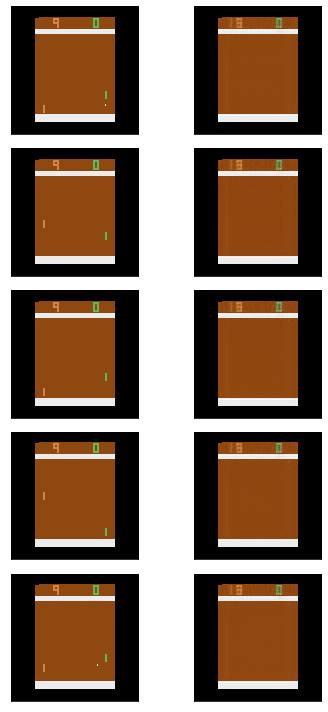

In [34]:
idx = 0
obs = obs_test[idx*batch_size:(idx+1)*batch_size,:,:,:]
obs = pad_along_axis(obs, 256, axis=[1,2])
pred = vae.decode(vae.encode(obs))

#a = vae.encode(X_train[idx*batch_size:(idx+1)*batch_size,:,:,:].reshape((100,64,64,3)))
#print(a.shape)
#decoded_imgs = vae.decode(a)
#print(logvar)


n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i, ind in enumerate(random.sample(range(batch_size), n)):
    # display original
    ax[i,0].imshow(obs[ind,:,:,:].reshape(256, 256, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(pred[ind,:,:,:].reshape(256, 256, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
    
    